In [7]:
!git checkout -b kaggle_pretraining origin/ppo_stable_baselines3_take_cover

Branch 'kaggle_pretraining' set up to track remote branch 'ppo_stable_baselines3_take_cover' from 'origin'.
Switched to a new branch 'kaggle_pretraining'


In [135]:
!pip install -q vizdoom==1.2.4 stable_baselines3==2.5.0 gymnasium==1.0.0 numpy==2.0.2 torch==2.5 tensorboard==2.18.0 tensorflow==2.18.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 43.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.0 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 82.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━

In [136]:
import stable_baselines3
import vizdoom
import os
import gymnasium

In [4]:
cd studienarbeit

/kaggle/working/studienarbeit


In [3]:
%%writefile vizdoom_env.py
import gymnasium
import vizdoom as vzd
import numpy as np
from torch.utils.tensorboard import SummaryWriter

def create_vizdoom_env():
    game = vzd.DoomGame()
    game.load_config("scenarios/move_n_avoid/take_cover.cfg")
    game.set_depth_buffer_enabled(True)
    game.set_labels_buffer_enabled(True)
    game.set_objects_info_enabled(True)
    
    class VizDoomGymEnv(gymnasium.Env):
        def __init__(self, game):
            self.game = game
            self.game.init()
            self.step_count = 0
            # Actually in the final run we restricted to use only certain actions, being basically move left and right
            self.available_actions = [
            [0, 0],  # no action
            [1, 0],  # move left
            [0, 1]]  # move right
            self.action_space = gymnasium.spaces.Discrete(len(self.available_actions))
            self.observation_space = gymnasium.spaces.Box(
                low=0,
                high=255,
                shape=(self.game.get_screen_height(), self.game.get_screen_width(), 3),
                dtype=np.uint8
            )
            # For repeated-action penalty, we added this because the agent became deterministic through the way they enemies attacked to force him into a corner. 
            self.last_action = None
            self.repeat_count = 0
            self.repeat_threshold = 5  # number of repeats allowed without penalty
            self.repeat_penalty = 0.5 # penalty per extra repeat
            
            self.kill_State = 0
            self.health = 100
            self.episode_count = 0
            self.writer = SummaryWriter(f"custom_metrics/env_{self.episode_count}")
        
        def reset(self, seed=None, options=None):
            super().reset(seed=seed)
            self.game.new_episode()
            self.kill_State = 0
            self.health = 100
            self.step_count = 0
            self.last_action = None
            self.repeat_count = 0
            self.writer = SummaryWriter(f"custom_metrics/env_{self.episode_count}")
            state = self.game.get_state()
            return self._process_observation(state), {}

        #Again in here happens all the reward shaping and collecting of custom metrics
        def step(self, action):
            self.step_count += 1
            done = self.game.is_episode_finished()
            action_list = self.available_actions[action]
            reward = self.game.make_action(action_list)

            # Repeated action penalty, which we didn't use the final run since it dind't work out
            #if self.last_action is not None and np.array_equal(action, self.last_action):
                #self.repeat_count += 1
            #else:
                #self.repeat_count = 0
            #if self.repeat_count > self.repeat_threshold:
                #penalty_amount = self.repeat_penalty * (self.repeat_count - self.repeat_threshold)
                #reward -= penalty_amount
                #self.writer.add_scalar("Game/RepeatActionPenalty", -penalty_amount, self.step_count)
            #self.last_action = action.copy()

            if self.game.get_state() is not None:
                state = self.game.get_state()
                game_variables = state.game_variables
                health, position_y, position_x = game_variables
                health_delta = health - self.health
                if health_delta < 0:
                    reward -= 0.5
                    self.writer.add_scalar("Game/HealthDelta", health_delta, self.step_count)
                self.health = health
                self.writer.add_scalar("Game/Health", health, self.step_count)

                #Change wall logic, to the y positions of the wall and penalize if he's wallhugging
                if self.best_vision(position_y):
                    reward+= 1                
                else:
                    reward -= 2
                self.writer.add_scalar("Game/Position", position_y, self.step_count)

            if done:
                self.writer.close()
                return (np.zeros(self.observation_space.shape, dtype=np.uint8), reward, done, False, {})

            state = self.game.get_state()
            if state is None:
                return (np.zeros(self.observation_space.shape, dtype=np.uint8), reward, done, False, {})
        
            return self._process_observation(state), reward, done, False, {}
            
        # To check if he's wallhugging or basically force him to try stay in the middle. Therefor we had to actually enter the vizdoom map config file ".wad" to check the max y values.
        def best_vision(self, y):
            """Check if agent ran into a wall, threshold 50"""
            return y <= 484 or y >= 284 

        def _process_observation(self, state):
            if state is None:
                return np.zeros(self.observation_space.shape, dtype=np.uint8)
            screen_buffer = state.screen_buffer.copy()
            return screen_buffer

        def render(self):
            state = self.game.get_state()
            if state is None:
                return np.zeros(self.observation_space.shape, dtype=np.uint8)
            return state.screen_buffer

        def close(self):
            self.writer.close()
            self.game.close()

    return VizDoomGymEnv(game)

Overwriting vizdoom_env.py


In [21]:
%%writefile ppo_pretraining.py
import gymnasium
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import DummyVecEnv,make_vec_env
from vizdoom_env import create_vizdoom_env  
import os 


# environment for each map
def make_env(map_name):
    """
    Utility function for creating a single environment.
    :param map_name: Name of the map configuration.
    :return: Callable function to create the environment.
    """
    return lambda: create_vizdoom_env(map=map_name)  # Ensure your `create_vizdoom_env` handles the `map` argument

if __name__ == '__main__':
    model_path = "ppo_vizdoom_model.zip"
    # Use SubprocVecEnv to handle multiple parallel environments
    envs = make_vec_env(lambda: create_vizdoom_env(), n_envs=12)  # Pass a callable
    # envs = DummyVecEnv([make_env(map_name) for map_name in maps])

    print(os.path.exists(model_path))

    if os.path.exists(model_path):
        model = PPO.load(model_path, envs, verbose=1,tensorboard_log="./ppo_vizdoom_tensorboard/", device="cuda")
        model.set_env(env=envs)
    else:
        model = PPO("CnnPolicy",
            envs,
            n_steps=2048,
            learning_rate=1e-4,
            ent_coef=0.01,
            clip_range=0.2,
            gamma=0.99,
            gae_lambda=0.95,
            verbose=1,
            tensorboard_log="./ppo_vizdoom_tensorboard/",
            device="cuda")
    
    timesteps= 1000000
    model.learn(timesteps,tb_log_name=f"PPO")
    model.save(f"{model_path}")
    envs.close()


Overwriting ppo_pretraining.py


In [13]:
%%writefile scenarios/move_n_avoid/take_cover.cfg

doom_scenario_path = take_cover.wad
doom_map = map01
doom_skill = 4

# Rewards
living_reward = 1

# Rendering options
screen_resolution = RES_160X120
screen_format = BGR24
render_hud = True
render_crosshair = True
render_weapon = True
render_decals = False
render_particles = False
window_visible = False

# Make episodes start in the first tic
episode_start_time = 1

# Available buttons
available_buttons =
	{
		MOVE_LEFT
		MOVE_RIGHT
	}

# Game variables that will be in the state
available_game_variables = 
    { 
        HEALTH
        POSITION_Y
        POSITION_X
    }


Overwriting scenarios/move_n_avoid/take_cover.cfg


In [34]:
!python3 ppo_pretraining.py

2025-05-04 14:22:14.317166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746368534.340731    5217 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746368534.347722    5217 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
True
Wrapping the env in a VecTransposeImage.
Wrapping the env in a VecTransposeImage.
Logging to ./ppo_vizdoom_tensorboard/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 216      |
|    ep_rew_mean     | 430      |
| time/              |          |
|    fps             | 724      |
|    iterations      | 1        |
|    time_elapsed    | 33       |
|    total_timesteps | 24576    |
-

In [148]:
%%writefile testModel.py
# Used to generate test runs, gather custom_metrics and analyze in a video what the agent is actually doing 
import gymnasium
import cv2
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from vizdoom_env import create_vizdoom_env  
import os 
import time

# Environment setup
def make_env(map_name=None):
    return lambda: create_vizdoom_env()

if __name__ == '__main__':
    model_path = "archive/tc_lvl5_1.zip"
    envs = make_vec_env(lambda: create_vizdoom_env(), n_envs=1)
    model = PPO.load(model_path, env=envs, verbose=1)

    obs = envs.reset()

    # Get initial grayscale frame and convert to BGR for video
    frame = envs.envs[0].render()
    frame_shape = (frame.shape[1], frame.shape[0])  # (width, height)

    video_filename = "test_run.mp4"
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(video_filename, fourcc, 30.0, frame_shape)

    for _ in range(4000):
        action, _ = model.predict(obs)
        obs, rewards, dones, _ = envs.step(action)

        frame = envs.envs[0].render()

        # Convert grayscale to BGR so OpenCV can write it
        out.write(frame)

        if dones.any():
            obs = envs.reset()

        time.sleep(0.005)

    out.release()
    envs.close()
    print(f"Video saved as {video_filename}")


Overwriting testModel.py


# Aggregating the tensorboard metrics for the final run, since we couldn't work with tensorboard in kaggle

In [13]:
#Aggregate tensorboard metrics
ep_len = []
ep_rew = []
approx_kl = []
explained = []
loss = []
value_loss = []
for event_file in os.listdir("ppo_vizdoom_tensorboard/PPO_1/"):
    event_file_path = os.path.join("ppo_vizdoom_tensorboard/PPO_1/", event_file)
    for summary in tf.compat.v1.train.summary_iterator(event_file_path):
        for v in summary.summary.value:
            if v.tag=="rollout/ep_len_mean": ep_len.append(v.simple_value)
            elif v.tag=="rollout/ep_rew_mean": ep_rew.append(v.simple_value)
            elif v.tag=="train/approx_kl": approx_kl.append(v.simple_value)
            elif v.tag=="train/explained_variance": explained.append(v.simple_value)
            elif v.tag=="train/loss": loss.append(v.simple_value)
            elif v.tag=="train/value_loss": value_loss.append(v.simple_value)

FileNotFoundError: [Errno 2] No such file or directory: 'ppo_vizdoom_tensorboard/PPO_1/'

# Plotting the tensorboard metrics for the final run, since we couldn't work with tensorboard in kaggle

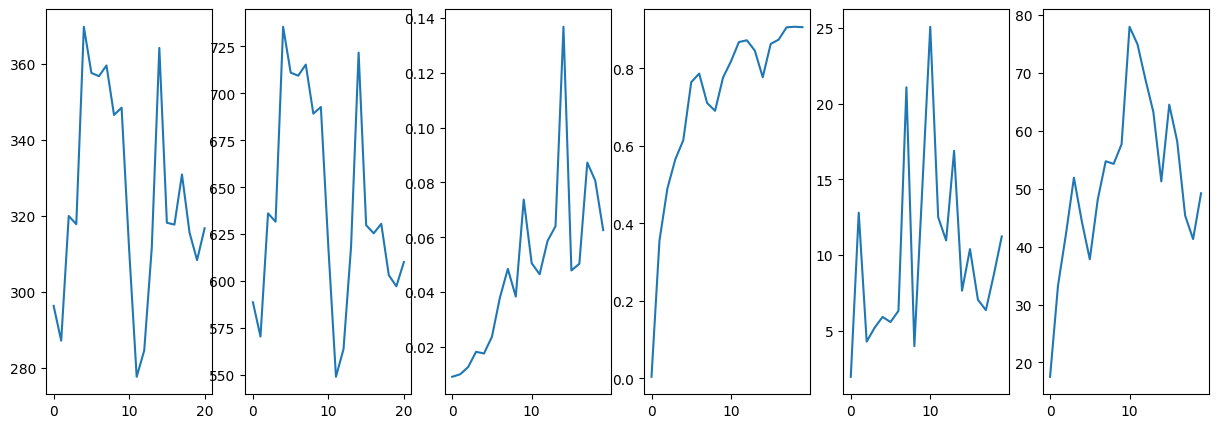

In [28]:
fig, axes = plt.subplots(ncols=6, nrows=1, figsize=(15, 5))
axes[0].plot(ep_len)
axes[1].plot(ep_rew)
axes[2].plot(approx_kl)
axes[3].plot(explained)
axes[4].plot(loss)
axes[5].plot(value_loss)

In [ ]:
Final solution: 
Main goal: Stay in the area, Secondary goal: Avoid losing health
LVl1-Lvl4: Trained for 250k steps
Lvl5_1: 2M steps
Lvl5_2: 1M steps, 
Lvl5_3 1M steps, 

# Aggregating the tensorboard metrics across all curriculum runs, to track the overall progress

In [4]:
import os
import tensorflow as tf
from natsort import natsorted  # pip install natsort

# Root folder containing PPO_1/, PPO_2/, etc.
base_logdir = "ppo_vizdoom_tensorboard"

# Initialize metric lists
ep_len = []
ep_rew = []
approx_kl = []
explained = []
loss = []
value_loss = []

# Helper function to extract values
def extract_metrics(event_file_path):
    for summary in tf.compat.v1.train.summary_iterator(event_file_path):
        for v in summary.summary.value:
            if v.tag == "rollout/ep_len_mean":
                ep_len.append(v.simple_value)
            elif v.tag == "rollout/ep_rew_mean":
                ep_rew.append(v.simple_value)
            elif v.tag == "train/approx_kl":
                approx_kl.append(v.simple_value)
            elif v.tag == "train/explained_variance":
                explained.append(v.simple_value)
            elif v.tag == "train/loss":
                loss.append(v.simple_value)
            elif v.tag == "train/value_loss":
                value_loss.append(v.simple_value)

# Traverse PPO_1, PPO_2, ... in natural order
for run_dir in natsorted(os.listdir(base_logdir)):
    full_run_path = os.path.join(base_logdir, run_dir)
    if os.path.isdir(full_run_path):
        for event_file in os.listdir(full_run_path):
            print(full_run_path)
            if "events.out.tfevents" in event_file:
                event_file_path = os.path.join(full_run_path, event_file)
                extract_metrics(event_file_path)

# You can now plot or further process the full training metrics
print("Total data points collected:")
print(f"Episode Length: {len(ep_len)}")

print(f"Episode Reward: {len(ep_rew)}")
print(f"Approx KL: {len(approx_kl)}")
print(f"Explained Variance: {len(explained)}")
print(f"Loss: {len(loss)}")
print(f"Value Loss: {len(value_loss)}")

2025-07-15 09:43:31.520370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752572612.034647      30 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752572612.176725      30 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


ppo_vizdoom_tensorboard/extended
ppo_vizdoom_tensorboard/extended
ppo_vizdoom_tensorboard/extended
ppo_vizdoom_tensorboard/extended
ppo_vizdoom_tensorboard/tc_lvl1
ppo_vizdoom_tensorboard/tc_lvl2
ppo_vizdoom_tensorboard/tc_lvl3
ppo_vizdoom_tensorboard/tc_lvl4
ppo_vizdoom_tensorboard/tc_lvl5
Total data points collected:
Episode Length: 126
Episode Reward: 126
Approx KL: 121
Explained Variance: 121
Loss: 121
Value Loss: 121


# Plotting the tensorboard metrics across all curriculum runs, to track the overall progress

/tmp/ipykernel_30/3861956481.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


Processing: extended
Processing: tc_lvl1
Processing: tc_lvl2
Processing: tc_lvl3
Processing: tc_lvl4
Processing: tc_lvl5


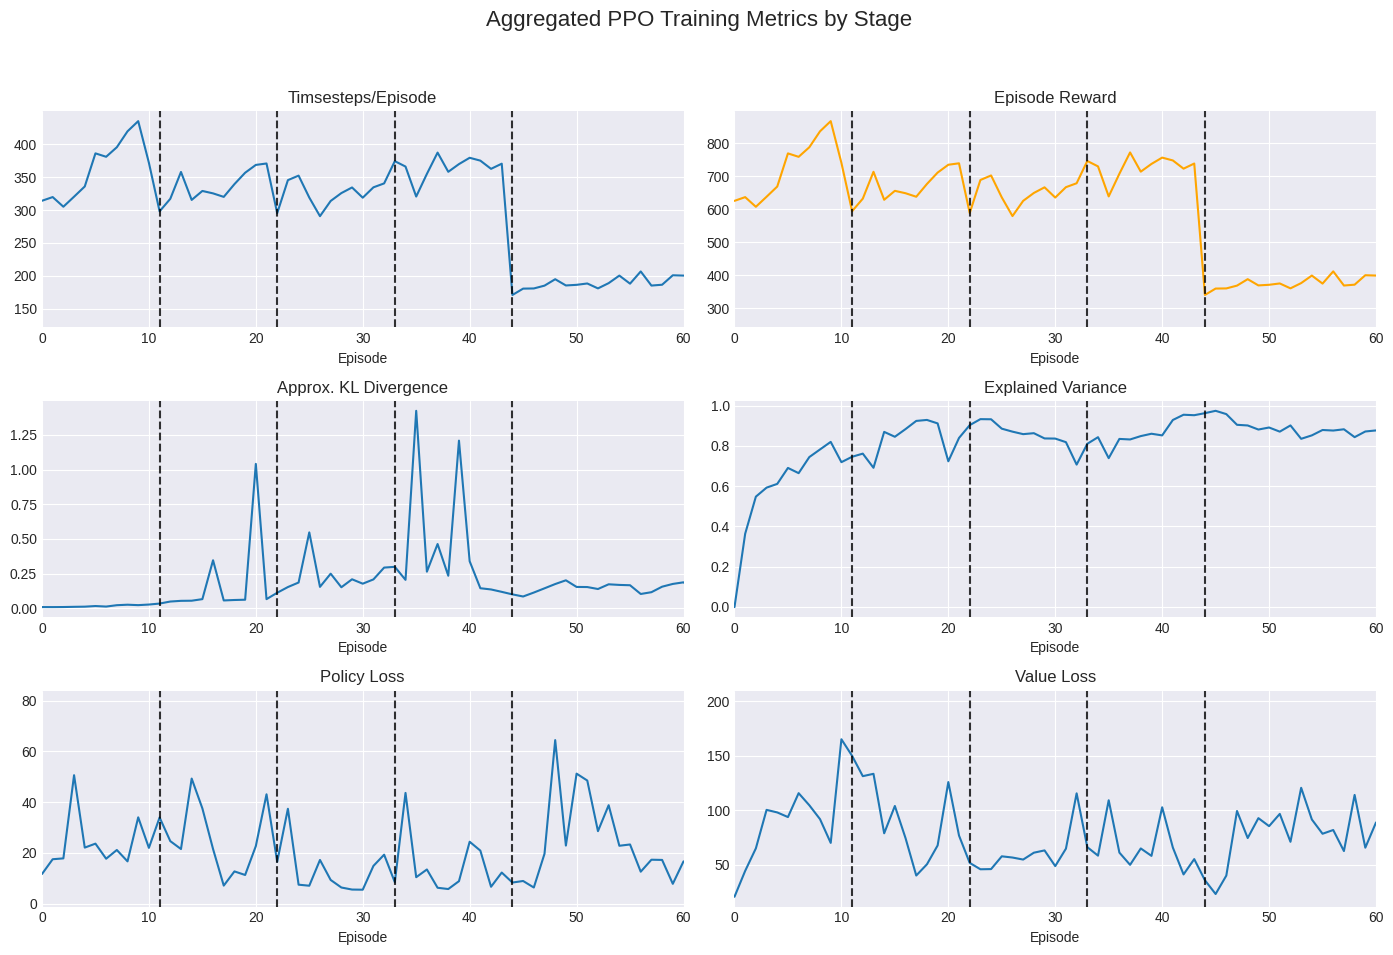

In [5]:
import os
import tensorflow as tf
from natsort import natsorted
import matplotlib.pyplot as plt
plt.style.use("seaborn-darkgrid")
def extract_metrics(event_file_path):
    """
    Extracts relevant training metrics from a TensorBoard event file.
    """
    ep_len, ep_rew = [], []
    approx_kl, explained = [], []
    loss, value_loss = [], []

    for summary in tf.compat.v1.train.summary_iterator(event_file_path):
        for v in summary.summary.value:
            tag = v.tag
            val = v.simple_value
            if tag == "rollout/ep_len_mean":
                ep_len.append(val)
            elif tag == "rollout/ep_rew_mean":
                ep_rew.append(val)
            elif tag == "train/approx_kl":
                approx_kl.append(val)
            elif tag == "train/explained_variance":
                explained.append(val)
            elif tag == "train/loss":
                loss.append(val)
            elif tag == "train/value_loss":
                value_loss.append(val)

    return ep_len, ep_rew, approx_kl, explained, loss, value_loss

def load_all_metrics(base_logdir):
    """
    Loads and aggregates metrics from all PPO runs in the base directory.
    Returns aggregated lists and stage boundaries.
    """
    ep_len_total, ep_rew_total = [], []
    approx_kl_total, explained_total = [], []
    loss_total, value_loss_total = [], []
    stage_boundaries = []
    stage_names = []

    for run_dir in natsorted(os.listdir(base_logdir)):
        full_run_path = os.path.join(base_logdir, run_dir)
        if not os.path.isdir(full_run_path):
            continue
        
        print(f"Processing: {run_dir}")
        event_files = [f for f in os.listdir(full_run_path) if "events.out.tfevents" in f]

        # Aggregate metrics for this stage
        ep_len_stage, ep_rew_stage = [], []
        approx_kl_stage, explained_stage = [], []
        loss_stage, value_loss_stage = [], []

        for ef in event_files:
            ef_path = os.path.join(full_run_path, ef)
            lel, ler, lakl, lexp, lloss, lval_loss = extract_metrics(ef_path)
            ep_len_stage.extend(lel)
            ep_rew_stage.extend(ler)
            approx_kl_stage.extend(lakl)
            explained_stage.extend(lexp)
            loss_stage.extend(lloss)
            value_loss_stage.extend(lval_loss)

        # Append to total metrics
        ep_len_total.extend(ep_len_stage)
        ep_rew_total.extend(ep_rew_stage)
        approx_kl_total.extend(approx_kl_stage)
        explained_total.extend(explained_stage)
        loss_total.extend(loss_stage)
        value_loss_total.extend(value_loss_stage)

        # Record stage boundary (current length of ep_len_total)
        if ep_len_total:
            stage_boundaries.append(len(ep_len_total))
            stage_names.append(run_dir)

    return (ep_len_total, ep_rew_total, approx_kl_total, explained_total,
            loss_total, value_loss_total, stage_boundaries, stage_names)

def plot_metrics(metrics, stage_boundaries):
    """
    Plot the aggregated PPO training metrics with vertical lines marking stage boundaries.
    """
    fig, axs = plt.subplots(3, 2, figsize=(14, 10))
    fig.suptitle("Aggregated PPO Training Metrics by Stage", fontsize=16)

    titles_axes = [
        ("Timsesteps/Episode", axs[0, 0]),
        ("Episode Reward", axs[0, 1]),
        ("Approx. KL Divergence", axs[1, 0]),
        ("Explained Variance", axs[1, 1]),
        ("Policy Loss", axs[2, 0]),
        ("Value Loss", axs[2, 1]),
    ]

    for (data, (title, ax)) in zip(metrics, titles_axes):
        if title == "Episode Reward":
            ax.plot(data, color='orange')  # reward line orange
        else:
            ax.plot(data)
        ax.set_title(title)
        ax.set_xlabel("Episode")
        ax.set_xlim(left=0, right=60)  # limit x-axis to 60

        # Draw vertical lines for stage boundaries (except last)
        for boundary in stage_boundaries[:-1]:
            if boundary <= 60:
                ax.axvline(x=boundary, color='black', linestyle='--', linewidth=1.5, alpha=0.8)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


if __name__ == "__main__":
    base_logdir = "ppo_vizdoom_tensorboard"

    metrics = load_all_metrics(base_logdir)  # Unpack the returned tuple

    plot_metrics(metrics[:-2], metrics[-2])  # Pass metrics (excluding stage_names) and stage_boundaries


# Didn't commit the custom_metrics since they didn't provide any valuable insights...you can generate them by running the testModel.py script

In [127]:
!git branch

  kaggle_pretraining
  master
* pretraining/stable_baselines_PPO_take_cover_final


In [123]:
!git lfs install

Updated git hooks.
Git LFS initialized.


In [124]:
!git lfs track "*.zip"

"*.zip" already supported


In [105]:
!git checkout -b pretraining/stable_baselines_PPO_take_cover_final

fatal: A branch named 'pretraining/stable_baselines_PPO_take_cover_final' already exists.


In [126]:
!git add -A
!git add .gitattributes

In [134]:
!git commit -m "Final commit for take cover, Agent can't seem to outplay the enemies, when forcing him into a corner!"
!git push -u origin pretraining/stable_baselines_PPO_take_cover_final

Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@f171419b0851.(none)')
Uploading LFS objects: 100% (9/9), 643 MB | 0 B/s, done.                        
Enumerating objects: 33349, done.
Counting objects: 100% (33349/33349), done.
Delta compression using up to 4 threads
Compressing objects: 100% (33323/33323), done.
Writing objects: 100% (33349/33349), 213.55 MiB | 38.17 MiB/s, done.
Total 33349 (delta 23), reused 33349 (delta 23), pack-reused 0
remote: Resolving deltas: 100% (23/23), done.
remote: 
remote: Create a pull request for 'pretraining/stable_baselines_PPO_take_cover_final' on GitHub by visiting:
remote:      https://github.com/leandergmeiner/studienarbeit/pull/new/pretraining/stable_baselines_PPO_take_cover_final
rem

In [145]:
%%writefile take_cover.cfg

doom_scenario_path = take_cover.wad
doom_map = map01
doom_skill = 5

# Rewards
living_reward = 1

# Rendering options
screen_resolution = RES_160X120
screen_format = BGR24
render_hud = True
render_crosshair = True
render_weapon = True
render_decals = False
render_particles = False
window_visible = False

# Make episodes start in the first tic
episode_start_time = 1

# Available buttons
available_buttons =
	{
		MOVE_LEFT
		MOVE_RIGHT
	}

# Game variables that will be in the state
available_game_variables = 
    { 
        HEALTH
        POSITION_Y
        POSITION_X
    }


Overwriting take_cover.cfg


In [149]:
!python3 testModel.py

2025-07-15 11:00:28.394279: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752577228.417641    1903 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752577228.424671    1903 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Wrapping the env in a VecTransposeImage.
Video saved as test_run.mp4
